# Cloudbow Analysis


This notebook analyses the effect of the medium microphysical properties on the measured polarization and radiance and cloudbow properties. 

---

Relevant papers:
- François‐Marie Bréon  Philippe Goloub, "Cloud droplet effective radius from spaceborne polarization measurements", 1998. https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/98GL01221
- F.M. Breon, M. Doutriaux-Boucher, "A comparison of cloud droplet radii measured from space", 2005. https://ieeexplore.ieee.org/document/1487637

In [1]:
"""
Imports necessary for this notebook
"""
import os 
import matplotlib.pyplot as plt
import numpy as np
import shdom
import itertools

In [36]:
"""
Function definitions necessary for this notebook
"""
def get_mie(wavelength):
    directory = '../mie_tables/polydisperse/'
    filename = 'Water_{:d}nm.scatpol'.format(shdom.int_round(wavelength))
    input_path = os.path.join(directory, filename)
    mie = shdom.MiePolydisperse()
    mie.read_table(input_path)
    return mie 


def get_atmosphere(mie_table, csv_path, veff):
    
    wavelength = mie_table.wavelength
    droplets = shdom.MicrophysicalScatterer()
    droplets.load_from_csv(csv_path, veff)
    droplets.add_mie(mie_table)
    
    # Rayleigh scattering for air molecules
    temperatures = np.array([283.64, 283.41, 283.17, 282.94, 282.72, 282.50, 282.29, 282.11,
                             281.95, 281.82, 281.69, 281.58, 281.50, 281.71, 283.87, 286.190])
    air_molecules_grid = shdom.Grid(z=droplets.grid.z)
    temperature_profile = shdom.GridData(air_molecules_grid, temperatures)
    
    
    rayleigh = shdom.Rayleigh(wavelength)
    rayleigh.set_profile(temperature_profile)

    atmospheric_grid = droplets.grid + air_molecules_grid
    atmosphere = shdom.Medium(atmospheric_grid)
    atmosphere.add_scatterer(droplets.get_optical_scatterer(wavelength), name='droplets')
    atmosphere.add_scatterer(rayleigh.get_scatterer(), name='air')
    return atmosphere


def get_rte_solver(csv_path, wavelengths, veffs, solar_angles):
    
    if isinstance(wavelengths, list):
        mie_tables = [get_mie(wavelength) for wavelength in wavelengths]
    else:
        mie_tables = [get_mie(wavelengths)]
        
    rte_solvers = shdom.RteSolverArray()
    solar_spectrum = shdom.SolarSpectrum('../ancillary_data/SpectralSolar_MODWehrli_1985_WMO.npz')
    solar_fluxes = solar_spectrum.get_monochrome_solar_flux(wavelengths) 
    solar_flux = solar_fluxes / max(solar_fluxes)
    for mie_table, wavelength, solar_flux in zip(mie_tables, wavelengths, solar_fluxes):
        for veff, (zenith, azimuth) in itertools.product(veffs, solar_angles):
            solar_flux = 1.0
            numerical_params = shdom.NumericalParameters(split_accuracy=0.1)
            scene_params = shdom.SceneParameters(
                wavelength=wavelength,
                source=shdom.SolarSource(azimuth, zenith, solar_flux),
                boundary_conditions={'y': shdom.BC.periodic, 'x': shdom.BC.periodic},
            )
            rte_solver = shdom.RteSolver(scene_params, numerical_params, num_stokes=3)
            atmosphere = get_atmosphere(mie_table, csv_path, veff)
            rte_solver.set_medium(atmosphere)
            rte_solvers.add_solver(rte_solver)
    return rte_solvers

## Mie scattering

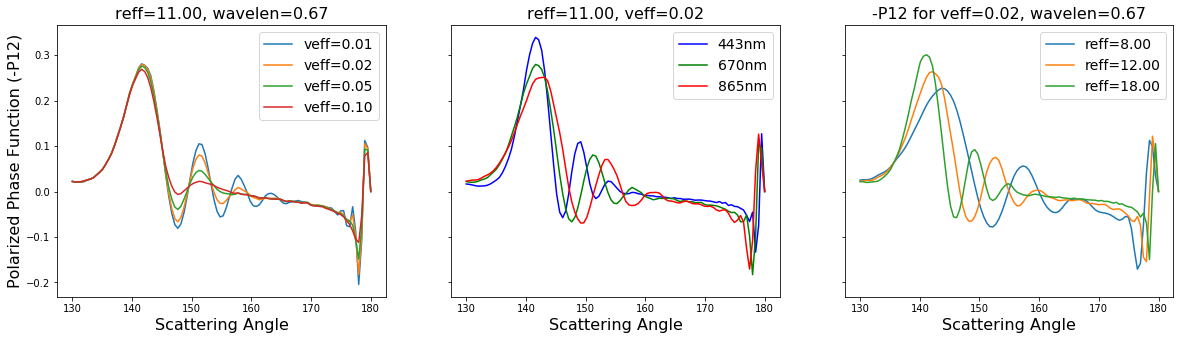

In [8]:
"""
Load Mie tables and plot polarized Mie scattering (-P12) for different effective radius, variance and wavelengths

Note
-----
To generate new mie tables see: scripts/generate_mie_tables.py
"""

wavelengths = [0.443, 0.670, 0.865]
mie_tables = [get_mie(wavelength) for wavelength in wavelengths]

angles = np.linspace(130, 180, 100)

%matplotlib inline
f, axes = plt.subplots(1,3,figsize=(20,5), sharey=True)
# ------------ Scattering for different veff ------------- #
reff = 11.0
veffs = [0.01, 0.02, 0.05, 0.10]
wavlength_index = 1
wavelength = wavelengths[wavlength_index]
for veff in veffs:
    phase = -mie_tables[wavlength_index].get_angular_scattering(reff, veff, angles, phase_element=5)
    axes[0].plot(angles, phase, label='veff={:.2f}'.format(veff))
    axes[0].set_title('reff={:.2f}, wavelen={:.2f}'.format(reff, wavelength), fontsize=16)
    axes[0].legend(fontsize=14)
    axes[0].set_xlabel('Scattering Angle', fontsize=16)
    axes[0].set_ylabel('Polarized Phase Function (-P12)', fontsize=16)

    
# --------- Scattering for different wavelengths ---------- #
colors = ['b', 'g', 'r']
reff, veff = 11.0, 0.02
for j, wavelength in enumerate(wavelengths):
    phase = -mie_tables[j].get_angular_scattering(reff, veff, angles, phase_element=5)
    axes[1].plot(angles, phase, label='{}nm'.format(shdom.int_round(wavelength)), color=colors[j])
    axes[1].set_title('reff={:.2f}, veff={:.2f}'.format(reff, veff), fontsize=16)
    axes[1].legend(fontsize=14)
    axes[1].set_xlabel('Scattering Angle', fontsize=16)
    
    
# --------- Scattering for different reff ---------- #
veff = 0.02
reffs = [8.0, 12.0, 18.0]
wavlength_index = 1
wavelength = wavelengths[wavlength_index]
for reff in reffs:
    phase = -mie_tables[j].get_angular_scattering(reff, veff, angles, phase_element=5)
    axes[2].plot(angles, phase, label='reff={:.2f}'.format(reff))
    axes[2].set_title('-P12 for veff={:.2f}, wavelen={:.2f}'.format(veff, wavelength), fontsize=16)
    axes[2].legend(fontsize=14)
    axes[2].set_xlabel('Scattering Angle', fontsize=16)

## Cloudbow

In [41]:
"""
Load a Stratocumulus cloud field from SHDOM original distribution.
The atmosphere contains both Rayleigh and Mie scattering.

Solve for multiple atmospheric configurations:
    wavelengths, effective variances, (solar zeniths, solar azimuths)
    
Note:
For 3x2 atmospheric configurations run time is ~4.5 minutes
"""
csv_path = '../synthetic_cloud_fields/shdom/les_stcu.txt'
wavelengths = [0.443, 0.670, 0.865]
veffs = [0.01, 0.1]
solar_angles = [(180.0, 0.0), (165.0, 30.0)]

rte_solver = get_rte_solver(csv_path, wavelengths, veffs, solar_angles)
rte_solver.solve(maxiter=100) 

Reading mie table from file: ../mie_tables/polydisperse/Water_443nm.scatpol
Reading mie table from file: ../mie_tables/polydisperse/Water_670nm.scatpol
Reading mie table from file: ../mie_tables/polydisperse/Water_865nm.scatpol


In [42]:
"""
Define a camera projection model and render the stokes componenets
A cloudbow is simulated using a perspective camera

Note
For 3x3x3 atmospheric configurations and n_jobs=40 run time is ~1.25 minutes
"""
def stretch_histogram(img):
    return (img - img.min()) / (img.max() - img.min())

projection = shdom.PerspectiveProjection(fov=100, nx=500, ny=500, x=1.75, y=1.75, z=10.0)
projection.look_at_transform(point=[1.75, 1.75, 0.0], up=[1.0, 0.0, 0.0])
camera = shdom.Camera(shdom.StokesSensor(), projection)
stokes = camera.render(rte_solver, n_jobs=40)

stokes_b, stokes_g, stokes_r = np.split(stokes, len(wavelengths), axis=-1)
stokes_i = np.stack((stokes_r[0], stokes_g[0], stokes_b[0]), axis=2)
stokes_q = -np.stack((stokes_r[1], stokes_g[1], stokes_b[1]), axis=2)
stokes_u = np.stack((stokes_r[2], stokes_g[2], stokes_b[2]), axis=2)

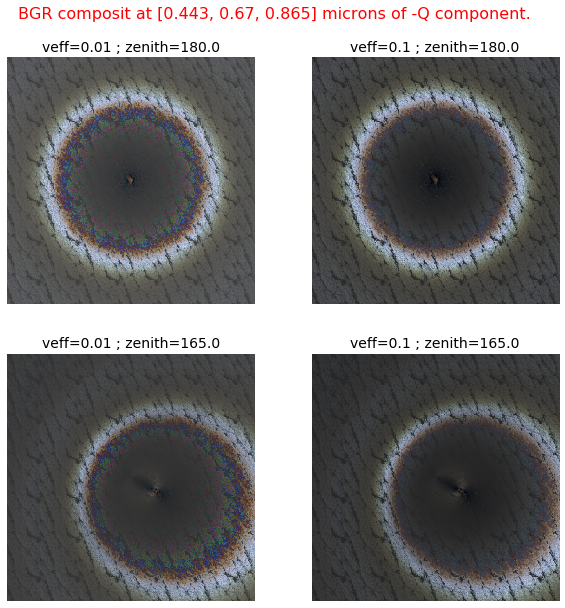

In [50]:
"""
Plot a composite RGB image for -Q of the stokes vector
"""
%matplotlib inline
num_rows = len(solar_angles)
num_cols = len(veffs)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
axes = np.atleast_2d(axes)
fig.suptitle('BGR composit at [{}, {}, {}] microns of -Q component.'.format(*wavelengths), 
             fontsize=16, color='r', y=0.95)
for row in range(num_rows):
    for col in range(num_cols):
        axes[row,col].imshow(stretch_histogram(stokes_q[...,col*num_rows + row]))
        axes[row,col].axis('off')
        axes[row,col].set_title('veff={} ; '.format(veffs[col]) + 
                            'zenith={}'.format(solar_angles[row][0]), fontsize=14)

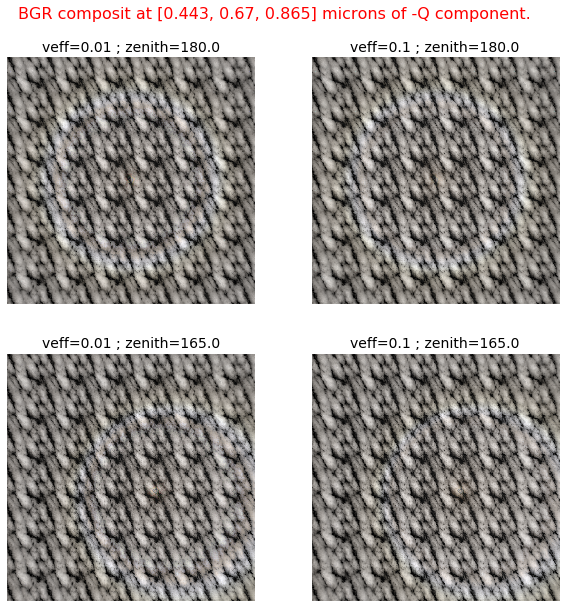

In [52]:
"""
Plot a composite RGB image for I of the stokes vector
"""
%matplotlib inline

num_rows = len(solar_angles)
num_cols = len(veffs)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))
axes = np.atleast_2d(axes)
fig.suptitle('BGR composit at [{}, {}, {}] microns of -Q component.'.format(*wavelengths), 
             fontsize=16, color='r', y=0.95)

for row in range(num_rows):
    for col in range(num_cols):
        axes[row,col].imshow(stretch_histogram(stokes_i[...,col*num_rows + row]))
        axes[row,col].axis('off')
        axes[row,col].set_title('veff={} ; '.format(veffs[col]) + 
                                 'zenith={}'.format(solar_angles[row][0]),fontsize=14)